# 2. Modelling


## To Do

Models:
- LogReg - GridSearch, Improve Precision ....
- Random Forest - GridSearch, Improve precision, Get feature importance to see main contributors
- MLPClassifier - more parameters, iterations, F1 scoring ...
- Best metrics, eg precision due the cost of a sales contact .... use f1 instead of accuracy .. but crashes
- Understand Hamming loss, Gini index (least is best etc)

And:
- MLP - Use Keras to create an MLP, see week 5 Wine notebook
- Add a loop like week 9 to produce a summary comparison? .. or just do manually in poster
- One best model found then retrain again and get different metrics??
- Repeat with PCA components
- Repeat with changes in features
- ?? SMOTE



## Imports & Utilities

In [1]:
# General stuff
import os
import time

# Import maths related packages
import pandas as pd
import numpy as np
import math

# Import plotting packages
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# Reset to Default
# plt.style.use('default')


In [2]:
# ML Models & Evaluation

from sklearn import model_selection

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline


In [3]:
# Function to Display The Model Fit Results

def print_search_results(search, duration):
    print('------- Search Results --------')
    all_search_results = pd.DataFrame(search.cv_results_)
    print(f"Score: {search.best_score_:.4f}. Mean: {np.mean(all_search_results['mean_test_score']):.4f} and STD {np.std(all_search_results['mean_test_score']):.4f}")
    print(f'Search Took: {duration:.2f} seconds')
    print(f"Best Parameters: {search.best_params_}")
    top_n = 10
    print(f"Top {top_n} out of {len(all_search_results)} combinations:")
    display(all_search_results[['rank_test_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time', 'params']].sort_values(by='rank_test_score').head(top_n))

In [4]:
# Function to Present the Evaluation Metrics for a Classification Model

def classification_metrics(for_Model, X_test, y_test, y_pred):
    plt.style.use('default')

    # Calculate Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Print various metrics
    print(f'Accuracy: {metrics.accuracy_score(y_true=y_test, y_pred=y_pred):.4f}')
    print(f'Precision: {metrics.precision_score(y_true=y_test, y_pred=y_pred, pos_label="yes"):.4f}')
    print(f'Recall: {metrics.recall_score(y_true=y_test, y_pred=y_pred, pos_label="yes"):.4f}')
    print(f'F1 Score {metrics.f1_score(y_true=y_test, y_pred=y_pred, pos_label="yes"):.4f}')
    print(f'Specificity: {tn / (tn + fp):.4f}')
    print(f'Hamming Loss {metrics.hamming_loss(y_true=y_test, y_pred=y_pred):.4f}')


    # Plot Confusion Matrix
    class_labels = for_Model.classes_
    fig, ax = plt.subplots(figsize=(12,4))
    ax.set_title('Confusion Matrix')
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels).plot(ax=ax)
    plt.show

    y_probabilities = for_Model.predict_proba(X_test)[:, 1]
    roc_auc_score = metrics.roc_auc_score(y_true=y_test, y_score=y_probabilities)
    print(f'ROC-AUC Score {roc_auc_score:.4f}')
    gini_score = 2 * roc_auc_score - 1
    print(f'Gini Index: {gini_score:.4f}')

    # Plot the ROC curve
    fig, ax = plt.subplots(figsize=(6,4))
    ax.set_title('ROC Curve')
    roc_display = RocCurveDisplay.from_estimator(for_Model, X_test, y_test, ax=ax, pos_label="yes")
    plt.show()

    plt.style.use('ggplot')

## Load the Prepared Data

In [5]:
# Load saved dataset
import pickle

with open('xy_data.pickle', 'rb') as file:
    X_train, X_test, y_train, y_test = pickle.load(file)

## Logistic Regression

In [ ]:
# Logistic Regression

# Establish a pipeline for a randomised search & get the best fitted model
logreg_pipeline = make_pipeline(
    LogisticRegression(random_state=42)
)
grid_params = {
    'logisticregression__penalty': ['l1', 'l2'],                # L1 or L2 regularisation
    'logisticregression__solver': ['saga', 'liblinear'],        # Saga is a variant of Sag. With L1 or l2. Large dataset. liblinear is for small datasets, binary classifications
    'logisticregression__C': [0.01, 0.1, 1, 5],                 # Strength of regularisation, default is 1, smaller is stronger
    'logisticregression__max_iter': [600],                      # Max 500 iterations seems to be sufficient
    'logisticregression__class_weight': ['balanced']            # Balanced seems to give a better recall & precision
    # 'logisticregression__class_weight': [None, 'balanced'] # Tries to adjust to balance for classes that are imbalanced
}
# scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
          
# Run the search
start_time = time.perf_counter()
# rand_search = RandomizedSearchCV(logreg_pipeline, grid_params, scoring=scoring, cv=5, refit='accuracy')
# rand_search = RandomizedSearchCV(logreg_pipeline, grid_params, scoring='accuracy', cv=5)
rand_search = GridSearchCV(logreg_pipeline, grid_params, scoring='accuracy', cv=5)

rand_search.fit(X_train, y_train)
duration = time.perf_counter() - start_time


In [ ]:
# Show the results
print_search_results(rand_search, duration)

# Get the Best Model & Calculate Predicted Y and Evaluate
model_logreg_rand = rand_search.best_estimator_
y_pred = model_logreg_rand.predict(X_test)
classification_metrics(model_logreg_rand, X_test, y_test, y_pred)

## Decision Tree - Random Forest

In [ ]:
# Decision Tree

# Establish a pipeline for a grid search & get the best fitted model
randforest_pipeline = make_pipeline(
    RandomForestClassifier(random_state=42)
)
grid_params = {
    'randomforestclassifier__n_estimators': [200, 400],            # Number of trees
    'randomforestclassifier__max_depth': [25, 50],
    'randomforestclassifier__max_leaf_nodes': [5, 50],
    'randomforestclassifier__min_samples_split': [2, 5],
    'randomforestclassifier__class_weight': ['balanced']    # Gives more importance to minority classes ... ?? Improves recall at the expense of precision
}                       

# Run the search
start_time = time.perf_counter()
grid_search = GridSearchCV(randforest_pipeline, grid_params, cv=5)
grid_search.fit(X_train, y_train)
duration = time.perf_counter() - start_time

In [ ]:
# Show the results
print_search_results(grid_search, duration)

# Get the Best Model & Calculate Predicted Y and Evaluate
model_randforest_grid = grid_search.best_estimator_
y_pred = model_randforest_grid.predict(X_test)
classification_metrics(model_randforest_grid, X_test, y_test, y_pred)

## Neural Network - MLPClassifier

In [ ]:
# Neural Network

    # 'Neural Network': {'hidden_layer_sizes': [(50,), (100,)], 'activation': ['relu', 'tanh']}

# param_grid = {
#     'hidden_layer_sizes': [(50,), (30, 15), (100,)],
#     'activation': ['relu', 'tanh'],
#     'solver': ['adam', 'lbfgs'],
#     'alpha': [0.0001, 0.001],
#     'learning_rate_init': [0.001, 0.01]
# }
# https://www.perplexity.ai/search/for-an-mlpclassifier-what-are-nqkwHGTVRRq6kH6L03t6gw


# Establish a pipeline for a grid or random search to get the best fitted model
mlpclass_pipeline = make_pipeline(
    MLPClassifier(random_state=42)
)
grid_params = {
    'mlpclassifier__hidden_layer_sizes': [(50,), (100,), (50, 25)],     # One layer: 50 and 100. Then a two layer
    'mlpclassifier__max_iter': [300]                                    # At 300 still several not converging


    # 'logisticregression__penalty': ['l1', 'l2'],                # L1 or L2 regularisation
    # 'logisticregression__solver': ['saga', 'liblinear'],        # Saga is a variant of Sag. With L1 or l2. Large dataset. liblinear is for small datasets, binary classifications
    # 'logisticregression__C': [0.01, 0.1, 1, 5],                 # Strength of regularisation, default is 1, smaller is stronger
    # 'logisticregression__max_iter': [600],                      # Max 500 iterations seems to be sufficient
    # 'logisticregression__class_weight': ['balanced']            # Balanced seems to give a better recall & precision
    # # 'logisticregression__class_weight': [None, 'balanced'] # Tries to adjust to balance for classes that are imbalanced
}
# scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

from sklearn.metrics import make_scorer, precision_score
# Create a custom scorer
custom_scorer = make_scorer(precision_score, pos_label='yes')


# Run the search
start_time = time.perf_counter()
# rand_search = RandomizedSearchCV(logreg_pipeline, grid_params, scoring=scoring, cv=5, refit='accuracy')
# rand_search = RandomizedSearchCV(logreg_pipeline, grid_params, scoring='accuracy', cv=5)
mlpclass_search = GridSearchCV(mlpclass_pipeline, grid_params, scoring=custom_scorer, cv=5)
# Accuracy and roc_auc scoring  are comparable,  ... can't get precision, f1 to work ... need label of 'no or 'yes in !?

mlpclass_search.fit(X_train, y_train)
duration = time.perf_counter() - start_time


/opt/anaconda3/envs/ml_v4/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/ml_v4/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/ml_v4/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/ml_v4/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/ml_v4/li

------- Search Results --------
Score: 0.5722. Mean: 0.5527 and STD 0.0139
Search Took: 10.96 seconds
Best Parameters: {'mlpclassifier__hidden_layer_sizes': (100,), 'mlpclassifier__max_iter': 10}
Top 10 out of 3 combinations:


,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
1,1,0.572240,0.752724,0.022996,"{'mlpclassifier__hidden_layer_sizes': (100,), ..."
2,2,0.544795,0.652932,0.021638,"{'mlpclassifier__hidden_layer_sizes': (50, 25)..."
0,3,0.541132,0.500280,0.022555,"{'mlpclassifier__hidden_layer_sizes': (50,), '..."


Accuracy: 0.8105
Precision: 0.5286
Recall: 0.1330
F1 Score 0.2125
Specificity: 0.9718
Hamming Loss 0.1895
ROC-AUC Score 0.7289
Gini Index: 0.4578


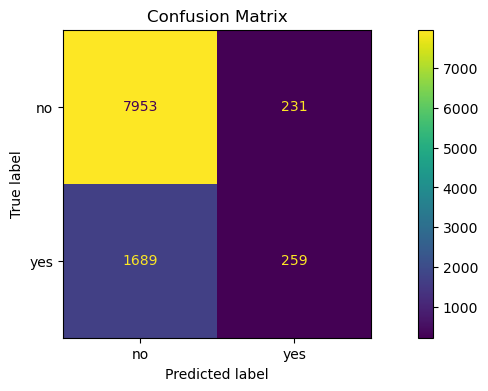

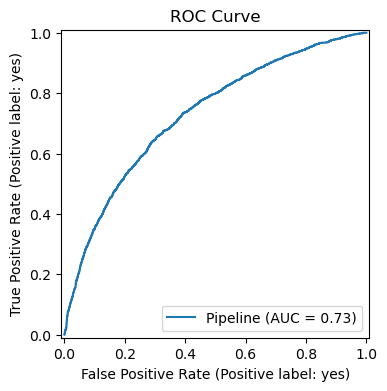

In [7]:
# Show the results
print_search_results(mlpclass_search, duration)

# Get the Best Model & Calculate Predicted Y and Evaluate
model_mlpclass = mlpclass_search.best_estimator_
y_pred = model_mlpclass.predict(X_test)
classification_metrics(model_mlpclass, X_test, y_test, y_pred)

# ?? use
# print("The probabilities across the possible classes for that output are", model.predict_proba(X_test[0:1]))

# from sklearn.model_selection import cross_val_score
# cv_accuracy = np.mean(cross_val_score(model_clf, X_train, y_train, cv=5))
# print(cv_accuracy)